In [11]:
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, Normalizer, OrdinalEncoder, StandardScaler, FunctionTransformer, KBinsDiscretizer, Binarizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Import Data

In [12]:
housing = pd.read_csv('C:/Users/erler/OneDrive/Documents/Random Data Sets/zillow/properties_2017.csv')
#housing = housing.set_index('parcelid')
#get rid of duplicates (it's possible they are condos but either way it biases tree algs)
z = [x for x in list(housing.columns) if x not in ['parcelid']]
housing = housing.drop_duplicates(keep = 'first', subset=z)

#drop floats which are primarily Nan
housing = housing.drop([x for x in list(housing.columns) if 
                        housing[x].isna().sum()/len(housing) > .9 and housing[x].dtypes == float  and housing[x].dtypes == float and housing[x].nunique() > 10], axis = 1)

#remove those related to the land
land= ['propertylandusetypeid', 'lotsizesquarefeet', 'regionidcity', 'regionidneighborhood', 'censustractandblock', 
       'longitude', 'latitude', 'regionidcounty','regionidzip', 'rawcensustractandblock', 'propertycountylandusecode',
                        'propertyzoningdesc', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

#combine pool features
pools = ['poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7']
housing['no_pool']= housing[pools].isna().apply(lambda x: all(x), axis=1)
housing['no_pool']=housing['no_pool']*1
housing = housing.drop(pools, axis=1)

others = ['parcelid', 'calculatedbathnbr', 'assessmentyear', 'taxdelinquencyflag','numberofstories',
 'roomcnt', 'fireplacecnt', 'fips', 'fireplaceflag', 'fullbathcnt', 'calculatedfinishedsquarefeet', 'garagetotalsqft']

housing = housing.drop(others, axis=1)

#Get rid of farms and other extremes
housing = housing.drop(housing.loc[housing['finishedsquarefeet12']>10000].index).reset_index(drop=True)
housing = housing.drop(housing.loc[housing['structuretaxvaluedollarcnt']>10000000].index).reset_index(drop=True)
housing = housing.drop(housing.loc[housing['lotsizesquarefeet']>3000000].index).reset_index(drop=True)
housing = housing.drop(housing.loc[housing['landtaxvaluedollarcnt']<2000].index).reset_index(drop=True)

#there are a sparse number of units above 6 and many have very high values. So max set to 6+
housing.unitcnt.iloc[housing['unitcnt'].loc[housing['unitcnt']>=6].index]='6+'
#there are a sparse number of bedrooms 10 or above. So max set to 10+
housing.bedroomcnt.iloc[housing['bedroomcnt'].loc[housing['bedroomcnt']>=10].index]='10+'
#there are a sparse number of bathrooms at 6.5+ or above. So max set to 6.5+
housing.bathroomcnt.iloc[housing['bathroomcnt'].loc[housing['bathroomcnt']>=6.5].index]='6.5+'
#there are a sparse number of garages at 7+ or above. So max set to 7+
housing.garagecarcnt.iloc[housing['garagecarcnt'].loc[housing['garagecarcnt']>=7].index]='7+'

#Remove all observations which have null values for the following variables
housing=housing.dropna(subset=['landtaxvaluedollarcnt', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt'])
#Drop variables which relate to the land
housing = housing.drop(land, axis = 1)
#Determine quantity of observations to use
housing= housing.iloc[:100000,:].reset_index(drop=True)

#for i in housing:
 #   if housing[i].nunique()/len(housing)>.005:
  #      housing[i] = housing[i].astype('float')

## Preprocess data in pipeline

In [13]:
cat_attribs = list(set(list(housing.loc[:,housing.nunique() < 300].columns) + list(housing.select_dtypes(exclude=[np.number]))))
num_attribs = [x for x in list(housing.columns) if x not in cat_attribs]
notcorrelated = [x for x in num_attribs if abs(housing.structuretaxvaluedollarcnt.corr(housing[x], method='pearson')) <.05] 
housing = housing.drop(notcorrelated, axis=1)

#convert string to number
housing.hashottuborspa.loc[housing.hashottuborspa =='True'] = 1

X = housing.drop('structuretaxvaluedollarcnt', axis=1) # drop labels for training set
y = housing['structuretaxvaluedollarcnt'].copy()

#Assign variable groupings for preprocessing activities
ord_attribs= [] #ordinal variables      
cat_attribs = list(set(cat_attribs)) #for variables to be one-hot encoded
binned_cats = ['yearbuilt'] #bin before one-hot encoding
num_attribs = [x for x in num_attribs if x not in cat_attribs and x not in ord_attribs]

#cat_to_bin
bin_attribs = ['hashottuborspa', 'airconditioningtypeid','decktypeid', 'architecturalstyletypeid', 'buildingclasstypeid']
cat_attribs = [x for x in cat_attribs if x not in bin_attribs]

for i in cat_attribs:
    X[i] = X[i].astype(str)

try:
    num_attribs.remove('structuretaxvaluedollarcnt')
except:
    pass

#custom transformers
class KbinsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bins, fillval, encode, strategy):
        self.bins = bins
        self.fillval = fillval
        self.encode = encode
        self.strategy = strategy
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        #print('\>>>>>>>fit() called.\n')
        X_ = X.copy()
        X_ = X_.astype('float')
        bin_imputer = SimpleImputer(strategy='constant', fill_value = self.fillval)
        disc = KBinsDiscretizer(n_bins=self.bins, encode=self.encode, strategy=self.strategy)
        X_ = pd.DataFrame(bin_imputer.fit_transform(X_.values.reshape(-1, 1)))
        X_ = disc.fit_transform(X_.values.reshape(-1, 1))
        return X_
    
#custom transformer 1    
binned_cat_pipeline = Pipeline([
    ('kbins', KbinsTransformer(bins = 15, fillval= housing.yearbuilt.median(), encode='ordinal', strategy='quantile')),
    ])

pre_pipeline = ColumnTransformer([
    ("kbin_cat", binned_cat_pipeline, binned_cats), 
    ])

X[binned_cats] = pre_pipeline.fit_transform(X)

#simple transformers
num_pipeline = Pipeline([
        ('num_imputer', SimpleImputer(strategy="median")),
        #('log', FunctionTransformer(np.log1p)),
        ('MinMaxScaler', MinMaxScaler()),
        #('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ])

bin_pipeline = Pipeline([
    ('bin_imputer', SimpleImputer(strategy='constant', fill_value = 0.111)),
    ('binarizar', Binarizer(threshold=0.111)),
    ])

ord_pipeline = Pipeline([
    ('ord_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_enc', OrdinalEncoder()),
    ('MinMaxScaler', MinMaxScaler()),
    #('std_scaler2', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
        ('bin', bin_pipeline, bin_attribs),
        ("ord", ord_pipeline, ord_attribs),
    ])

#train model data
data_prepared = full_pipeline.fit_transform(X)

#reintroduce y values
data = pd.DataFrame(data_prepared.toarray())
data.columns = list(num_attribs)+list(full_pipeline.transformers_[1][1].named_steps['ohe'].get_feature_names(cat_attribs))+list(bin_attribs)+list(ord_attribs)
data_prepared = pd.concat([data, y.reset_index(drop=True)], axis= 1)

train_set, test_set = train_test_split(data_prepared, test_size=0.2, random_state=42)

#training set
training = train_set.drop('structuretaxvaluedollarcnt', axis=1) # drop labels for training set
training_labels = train_set['structuretaxvaluedollarcnt'].copy()

#test set
testing = test_set.drop('structuretaxvaluedollarcnt', axis=1) # drop labels for training set
testing_labels = test_set['structuretaxvaluedollarcnt'].copy()

# Search for Collinearity

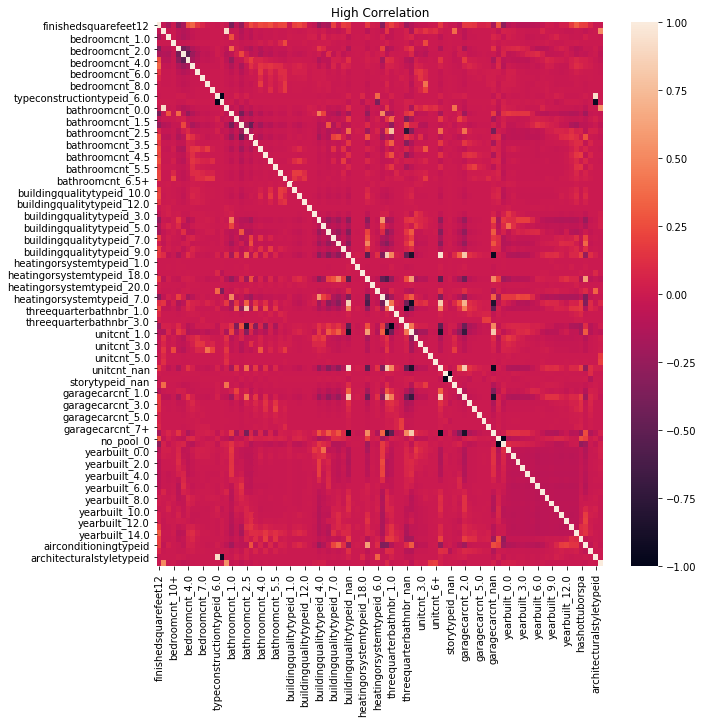

In [14]:
num_correlation = training.corr(method='pearson')
plt.figure(figsize=(10,10))
plt.title('High Correlation')
sns.heatmap(data=num_correlation, annot=False)

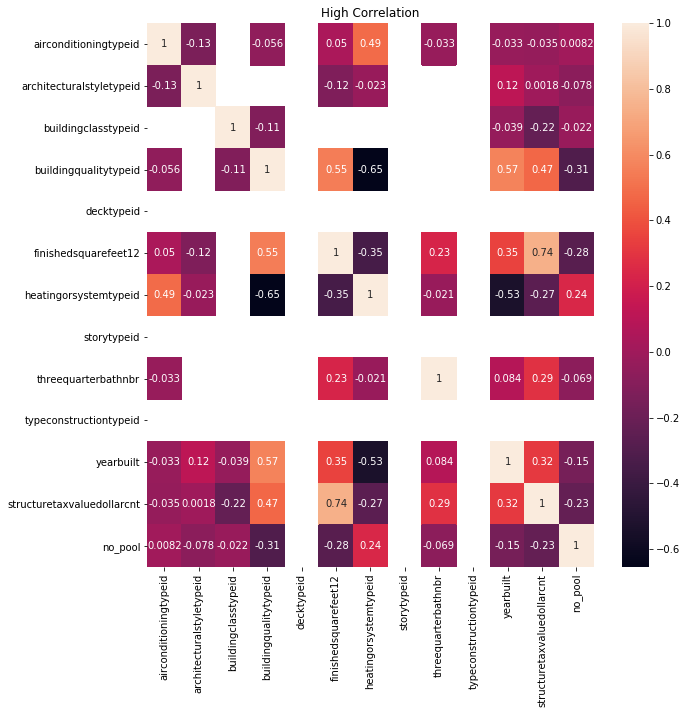

In [15]:
num_correlation = housing.corr(method='pearson')
plt.figure(figsize=(10,10))
plt.title('High Correlation')
sns.heatmap(data=num_correlation, annot=True)

## Adjustments based on VIF and p-values

In [16]:
dropped = []
C = .7 #max collinearity
corr_table = pd.DataFrame([1], columns=['r']) #little trick to establish starting max in corr_table
counter=0
while corr_table.r.max() > C:    
    table = []
    for i in training.columns:
        for j in training.columns:
            if i != j:
                if [j, i, abs(np.corrcoef(training[i], training[j])[0,1])] not in table:
                    table.append([i, j, abs(np.corrcoef(training[j], training[i])[0,1])])
    corr_table = pd.DataFrame(table, columns=['v1', 'v2', 'r']).sort_values(by='r', ascending = False).reset_index(drop=True) 
    #Drop one partner of variable pairs which have a correlation above max level
    collinearity_list = list(set([x for x in list(corr_table.v1.loc[corr_table.r>C]) if x not in list(corr_table.v2.loc[corr_table.r>C])]))
    dropped.append(collinearity_list)
    training = training.drop(collinearity_list, axis=1)
    testing = testing.drop(collinearity_list, axis=1)

In [17]:
corr_table

,v1,v2,r
0,heatingorsystemtypeid_2.0,airconditioningtypeid,0.61
1,buildingqualitytypeid_4.0,heatingorsystemtypeid_7.0,0.57
2,bathroomcnt_0.0,buildingclasstypeid,0.55
3,heatingorsystemtypeid_2.0,garagecarcnt_nan,0.52
4,threequarterbathnbr_nan,garagecarcnt_nan,0.51
...,...,...,...
3155,garagecarcnt_6.0,yearbuilt_2.0,0.00
3156,bathroomcnt_2.0,garagecarcnt_1.0,0.00
3157,heatingorsystemtypeid_1.0,threequarterbathnbr_3.0,0.00
3158,heatingorsystemtypeid_1.0,heatingorsystemtypeid_18.0,0.00


# Linear Regression 

,# of features,RMSE,r2
0,2,153985.95,0.46
1,3,152102.98,0.48
2,4,150876.02,0.48
3,5,149473.86,0.49
4,6,148568.61,0.50
5,7,147517.25,0.51
6,8,146105.72,0.52
7,9,145107.22,0.52
8,10,144717.27,0.53
9,11,144233.68,0.53


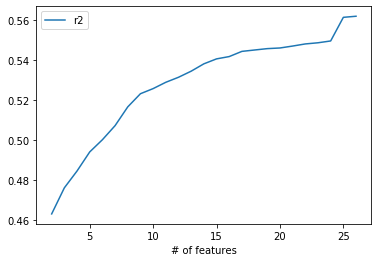

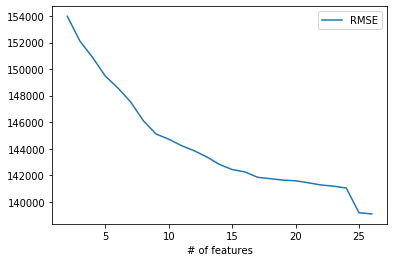

In [18]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lin_model = LinearRegression() #select model
v=26 #number of features

#feature selection
x=SFS(lin_model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results

for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    lin_model.fit(training[f], training_labels)
    pred = lin_model.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred)])
    #print(i)
       
facts = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2'])

facts.plot('# of features', 'r2')
facts.plot('# of features', 'RMSE')
facts

### Linear Metrics

In [19]:
#Select number of variables which results in lowerst RMSE
i=facts['# of features'].loc[facts['RMSE']==facts['RMSE'].min()].values[0]
#selct which variables are included
f = list(x.subsets_[i]['feature_names'][0:i])

model = lin_model
model.fit(training[f], training_labels)

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
pd.set_option('display.float_format', lambda x: '%.2f' % x)
estimates = pd.DataFrame(model.predict(testing[f]).reshape(-1,1))
print("median abs error: ", median_absolute_error(testing_labels, estimates))
print("r2: ", r2_score(testing_labels, estimates))
print('mean: ',estimates.mean())
print('rmse: ', mean_squared_error(testing_labels, estimates, squared = False))

median abs error:  38603.82013892676
r2:  0.5618617243939594
mean:  0   177681.04
dtype: float64
rmse:  139083.5329647244


In [21]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
x1 = pd.DataFrame({'names':list(training[f].columns), 'coefs':model.coef_})
home = []
for n,i in enumerate(training[f].columns):
    home.append([i, training[i].mean(), training[i].corr(training_labels), training[i].var(), training[i].std(), 
                 variance_inflation_factor(training[f].values, n)])
x2 = pd.DataFrame(home, columns = ['names', 'mean', 'r2', 'var', 'stdev', 'VIF']).sort_values(by='r2', ascending=False).head(50)

x1.merge(x2,left_on='names', right_on='names')

,names,coefs,mean,r2,var,stdev,VIF
0,finishedsquarefeet12,1176490.91,0.18,0.68,0.01,0.09,5.00
1,bedroomcnt_1.0,56784.68,0.02,-0.06,0.02,0.15,1.09
2,bedroomcnt_2.0,35539.88,0.19,-0.15,0.16,0.40,1.67
3,bedroomcnt_3.0,17743.50,0.40,-0.13,0.24,0.49,2.12
4,bathroomcnt_0.0,81077.39,0.02,0.05,0.02,0.13,1.49
5,bathroomcnt_3.5,47749.70,0.01,0.11,0.01,0.10,1.10
6,bathroomcnt_4.0,47987.01,0.05,0.18,0.05,0.21,1.24
7,bathroomcnt_4.5,124260.12,0.01,0.17,0.01,0.08,1.12
8,bathroomcnt_5.0,99125.41,0.01,0.23,0.01,0.12,1.22
9,bathroomcnt_5.5,297405.93,0.00,0.17,0.00,0.05,1.07


In [22]:
ols_model = sm.OLS(training_labels, training[f])
ols_results = ols_model.fit()
print(ols_results.summary())

                                     OLS Regression Results                                    
Dep. Variable:     structuretaxvaluedollarcnt   R-squared (uncentered):                   0.737
Model:                                    OLS   Adj. R-squared (uncentered):              0.737
Method:                         Least Squares   F-statistic:                              8635.
Date:                        Wed, 12 Aug 2020   Prob (F-statistic):                        0.00
Time:                                18:19:54   Log-Likelihood:                     -1.0612e+06
No. Observations:                       80000   AIC:                                  2.122e+06
Df Residuals:                           79974   BIC:                                  2.123e+06
Df Model:                                  26                                                  
Covariance Type:                    nonrobust                                                  
                                 coef   

# Lasso Regression

,# of features,RMSE,r2,alpha
0,2,153985.93,0.46,0.10
1,3,152102.97,0.48,0.10
2,4,150875.99,0.48,1.00
3,5,149473.89,0.49,0.10
4,6,148568.60,0.50,0.10
5,7,147517.27,0.51,0.10
6,8,146105.79,0.52,0.10
7,9,145107.31,0.52,0.10
8,10,144718.23,0.53,1.00
9,11,144234.64,0.53,1.00


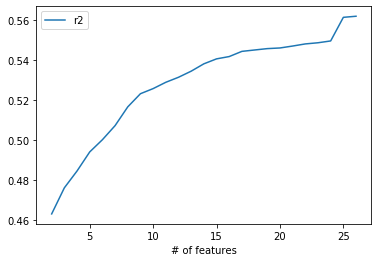

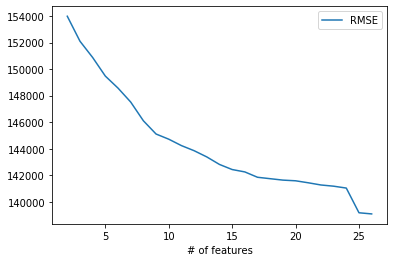

In [23]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = Lasso() #select model
v=26 #number of features

#feature selection
x=SFS(model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results
params = [{'alpha': [64, 4, 1, .1]}] #parameter tuning
for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    gridl = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
    gridl.fit(training[f], training_labels)
    pred = gridl.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred), gridl.best_estimator_.alpha])
    #print(i)
       
factsl = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2', 'alpha'])
factsl.plot('# of features', 'r2')
factsl.plot('# of features', 'RMSE')
factsl

### Lasso Metrics

In [24]:
#Select number of variables which results in lowerst RMSE
i=factsl['# of features'].loc[factsl['RMSE']==factsl['RMSE'].min()].values[0]
#selct which variables are included
f = list(x.subsets_[i]['feature_names'][0:i])

model = Lasso()
gridl.fit(training[f], training_labels)

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
pd.set_option('display.float_format', lambda x: '%.2f' % x)
estimates = pd.DataFrame(gridl.predict(testing[f]).reshape(-1,1))
print("median abs var: ", median_absolute_error(testing_labels, estimates))
print("r2: ", r2_score(testing_labels, estimates))
print('mean: ',estimates.mean())
print('rmse: ', mean_squared_error(testing_labels, estimates, squared = False))

median abs var:  38605.42307638074
r2:  0.5618528001759939
mean:  0   177681.02
dtype: float64
rmse:  139084.94941874399


In [25]:
grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
grid.fit(training[f], training_labels)
pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
#print(model.coef_)
print('{:.2f}'.format(grid.best_estimator_.intercept_))
x1 = pd.DataFrame({'names':list(training[f].columns), 'coefs':grid.best_estimator_.coef_})

pd.set_option('display.float_format', lambda x: '%.2f' % x)
home = []
for n,i in enumerate(training[f].columns):
    home.append([i, training[i].mean(), training[i].corr(training_labels), training[i].var(), training[i].std(), 
                 variance_inflation_factor(training[f].values, n)])
x2 = pd.DataFrame(home, columns = ['names', 'mean', 'r2', 'var', 'stdev', 'VIF']).sort_values(by='r2', ascending=False).head(50)

x1.merge(x2,left_on='names', right_on='names')

-72739.13


,names,coefs,mean,r2,var,stdev,VIF
0,finishedsquarefeet12,1176520.08,0.18,0.68,0.01,0.09,5.00
1,bedroomcnt_1.0,56781.29,0.02,-0.06,0.02,0.15,1.09
2,bedroomcnt_2.0,35538.90,0.19,-0.15,0.16,0.40,1.67
3,bedroomcnt_3.0,17741.43,0.40,-0.13,0.24,0.49,2.12
4,bathroomcnt_0.0,81076.19,0.02,0.05,0.02,0.13,1.49
5,bathroomcnt_3.5,47733.17,0.01,0.11,0.01,0.10,1.10
6,bathroomcnt_4.0,47982.22,0.05,0.18,0.05,0.21,1.24
7,bathroomcnt_4.5,124237.20,0.01,0.17,0.01,0.08,1.12
8,bathroomcnt_5.0,99118.56,0.01,0.23,0.01,0.12,1.22
9,bathroomcnt_5.5,297349.41,0.00,0.17,0.00,0.05,1.07


# Ridge Regression

In [26]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = Ridge() #select model
v=26 #number of features

#feature selection
x=SFS(model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results
params = [{'alpha': [10, 1,.1, .01]}] #parameter tuning
for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    gridr = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
    gridr.fit(training[f], training_labels)
    pred = gridr.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred), gridr.best_estimator_.alpha])
    #print(i)
       
factsr = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2', 'alpha'])
factsr

,# of features,RMSE,r2,alpha
0,2,153985.93,0.46,0.01
1,3,152102.98,0.48,0.01
2,4,150876.02,0.48,0.01
3,5,149473.87,0.49,0.01
4,6,148568.60,0.50,0.01
5,7,147517.24,0.51,0.01
6,8,146105.55,0.52,0.10
7,9,145107.02,0.52,0.10
8,10,144716.36,0.53,1.00
9,11,144233.56,0.53,0.10


### Ridge Regression metrics

In [27]:
#Select number of variables which results in lowerst RMSE
i=factsr['# of features'].loc[factsr['RMSE']==factsr['RMSE'].min()].values[0]
#selct which variables are included
f = list(x.subsets_[i]['feature_names'][0:i])

model = Ridge()
gridr.fit(training[f], training_labels)

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
pd.set_option('display.float_format', lambda x: '%.2f' % x)
estimates = pd.DataFrame(gridr.predict(testing[f]).reshape(-1,1))
print("median abs var: ", median_absolute_error(testing_labels, estimates))
print("r2: ", r2_score(testing_labels, estimates))
print('mean: ',estimates.mean())
print('rmse: ', mean_squared_error(testing_labels, estimates, squared = False))

median abs var:  38592.356526214746
r2:  0.5614612006157164
mean:  0   177678.71
dtype: float64
rmse:  139147.08999691196


In [28]:
grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
grid.fit(training[f], training_labels)
pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
#print(model.coef_)
print('{:.2f}'.format(grid.best_estimator_.intercept_))
x1 = pd.DataFrame({'names':list(training[f].columns), 'coefs':grid.best_estimator_.coef_})

pd.set_option('display.float_format', lambda x: '%.2f' % x)
home = []
for n,i in enumerate(training[f].columns):
    home.append([i, training[i].mean(), training[i].corr(training_labels), training[i].var(), training[i].std(), 
                 variance_inflation_factor(training[f].values, n)])
x2 = pd.DataFrame(home, columns = ['names', 'mean', 'r2', 'var', 'stdev', 'VIF']).sort_values(by='r2', ascending=False).head(50)

x1.merge(x2,left_on='names', right_on='names')

-72030.47


,names,coefs,mean,r2,var,stdev,VIF
0,finishedsquarefeet12,1173928.60,0.18,0.68,0.01,0.09,5.00
1,bedroomcnt_1.0,56427.53,0.02,-0.06,0.02,0.15,1.09
2,bedroomcnt_2.0,35320.33,0.19,-0.15,0.16,0.40,1.67
3,bedroomcnt_3.0,17605.91,0.40,-0.13,0.24,0.49,2.12
4,bathroomcnt_0.0,81145.77,0.02,0.05,0.02,0.13,1.49
5,bathroomcnt_3.5,47833.38,0.01,0.11,0.01,0.10,1.10
6,bathroomcnt_4.0,48131.38,0.05,0.18,0.05,0.21,1.24
7,bathroomcnt_4.5,124395.87,0.01,0.17,0.01,0.08,1.12
8,bathroomcnt_5.0,99501.91,0.01,0.23,0.01,0.12,1.22
9,bathroomcnt_5.5,296191.28,0.00,0.17,0.00,0.05,1.07


# Visualizations

,# of features,RMSE,r2,alpha
0,2,153985.93,0.46,0.01
1,3,152102.98,0.48,0.01
2,4,150876.02,0.48,0.01
3,5,149473.87,0.49,0.01
4,6,148568.60,0.50,0.01
5,7,147517.24,0.51,0.01
6,8,146105.55,0.52,0.10
7,9,145107.02,0.52,0.10
8,10,144716.36,0.53,1.00
9,11,144233.56,0.53,0.10


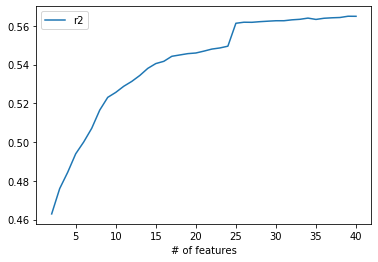

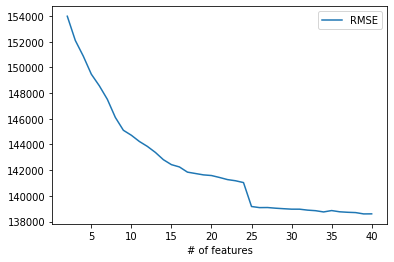

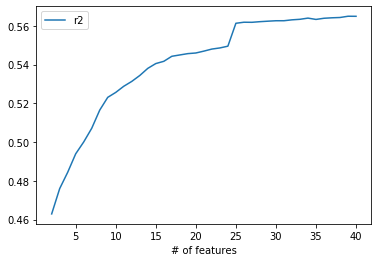

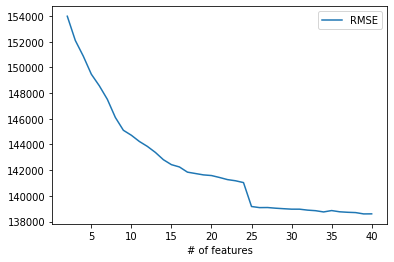

In [29]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lin_model = LinearRegression() #select model
v=40 #number of features

#feature selection
x=SFS(lin_model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results

for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    lin_model.fit(training[f], training_labels)
    pred = lin_model.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred)])
    #print(i)
       
facts = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2'])

facts.plot('# of features', 'r2')
facts.plot('# of features', 'RMSE')
facts

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = Lasso() #select model

#feature selection
x=SFS(model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results
params = [{'alpha': [64, 4, 1, .1]}] #parameter tuning
for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    gridl = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
    gridl.fit(training[f], training_labels)
    pred = gridl.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred), gridl.best_estimator_.alpha])
    #print(i)
       
factsl = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2', 'alpha'])
factsl.plot('# of features', 'r2')
factsl.plot('# of features', 'RMSE')
factsl

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = Ridge() #select model

#feature selection
x=SFS(model,
       k_features=v,
       forward=True,
       scoring='neg_root_mean_squared_error',
       n_jobs=-1,
       cv=3)

x.fit(training, training_labels)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

table =[] #establish table for results
params = [{'alpha': [10, 1,.1, .01]}] #parameter tuning
for i in range(2,v+1): #compile statistics on each number of features
    f = list(x.subsets_[i]['feature_names'][0:i])
    gridr = GridSearchCV(estimator=model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
    gridr.fit(training[f], training_labels)
    pred = gridr.predict(testing[f])
    rmse = mean_squared_error(testing_labels, pred, squared = False)
    table.append([i, rmse, r2_score(testing_labels, pred), gridr.best_estimator_.alpha])
    #print(i)
       
factsr = pd.DataFrame(table, columns=['# of features', 'RMSE', 'r2', 'alpha'])
factsr

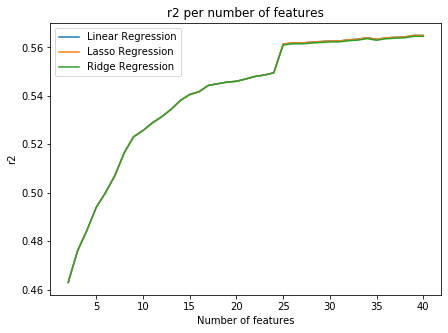

In [30]:
plt.figure(figsize=(7, 5))
plt.plot(facts['# of features'], facts['r2'], label = 'Linear Regression')
plt.plot(factsl['# of features'], factsl['r2'], label = 'Lasso Regression')
plt.plot(factsr['# of features'], factsr['r2'], label = 'Ridge Regression')
plt.xlabel('Number of features')
plt.ylabel('r2')
plt.title('r2 per number of features')
plt.legend()
plt.savefig('structure_r2.png')

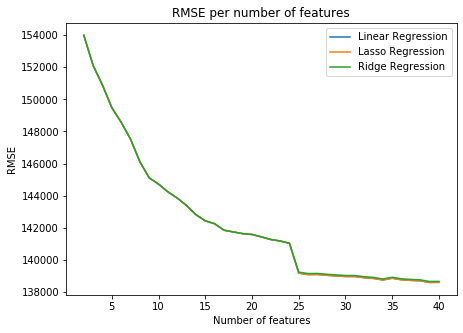

In [31]:
plt.figure(figsize=(7, 5))
plt.plot(facts['# of features'], facts['RMSE'], label = 'Linear Regression')
plt.plot(factsl['# of features'], factsl['RMSE'], label = 'Lasso Regression')
plt.plot(factsr['# of features'], factsr['RMSE'], label = 'Ridge Regression')
plt.xlabel('Number of features')
plt.ylabel('RMSE')
plt.title('RMSE per number of features')
plt.legend()
plt.savefig('structure_RMSE.png')

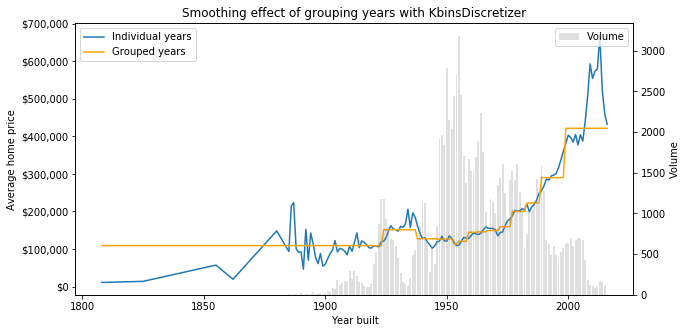

In [32]:
import matplotlib.ticker as ticker

#strategy{‘uniform’, ‘quantile’, ‘kmeans’}, (default=’quantile’)
binned_cat_pipeline = Pipeline([
    ('kbins', KbinsTransformer(bins = 15, fillval= housing.yearbuilt.median(), encode='ordinal', strategy='quantile')),
    ])

pre_pipeline = ColumnTransformer([
    ("kbin_cat", binned_cat_pipeline, binned_cats), 
    ])

housing['k_years'] = pre_pipeline.fit_transform(housing)

import matplotlib.ticker as mtick
grouped = pd.DataFrame(housing.groupby(['yearbuilt', 'k_years']).agg(
    price_year= pd.NamedAgg(column='structuretaxvaluedollarcnt', aggfunc= 'mean'),
    count_year= pd.NamedAgg(column='structuretaxvaluedollarcnt', aggfunc='count')
    )).reset_index()

df = pd.DataFrame(housing.groupby('k_years')['structuretaxvaluedollarcnt'].mean()).reset_index()
grouped = grouped.merge(df,left_on='k_years', right_on='k_years')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
grouped.plot(x='yearbuilt', y='price_year', ax=ax, label = 'Individual years')
grouped.plot(x='yearbuilt', y='structuretaxvaluedollarcnt', ax=ax, label = 'Grouped years', color = 'orange')
#grouped['count_year'].plot(x='yearbuilt', y='count_year', ax=ax, label = 'Volume years')

ax2 = ax.twinx()
ax2.set_ylabel('Volume')
ax2.bar(grouped['yearbuilt'], grouped['count_year'], color='grey', alpha=.25, label = 'Volume')
ax2.tick_params(axis='y')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)
plt.legend()
ax.set_xlabel('Year built')
ax.set_ylabel('Average home price', )
plt.title('Smoothing effect of grouping years with KbinsDiscretizer')
plt.savefig('structure_year_blend.png')